
- overall goal:
    - specific ROI targetting w/ minimal campaigns
- what this means for accnt structure
    - for many variables we must split campaigns to target ROI
    - want to capture greatest amt of rps variation w/ 
        fewest # of campaigns
- 2 ways of approaching this
    1. minimize rps variation w/in a campaign
        - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
        - tried this out a little - but the computation was intensive which made it slow going
    2. maximize rps variation outside campaigns
    - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    - mostly focused on this approach

- approaches I tried
1. rank splits by their correlation/covaraince/MI w/ `agg_rps`
    - tried ANOVA,pt.biserial,MI - had most success w/ MI
    - was dificult to compute b/c couldnt find methods that accepted sample weight
    - MI approach was promising but didnt go down that route
2. rank splits by intra-split agg_rps variance
    - had most success w/ this
    - tested out an approahc where I cluster the split on rps - had good results
    - think this is the mtd to use going forward
    TODO:
    - test fitting on general traffic sources?
    - test clustering on multiple days of rps data - 
        or rolling rps data or something
    - try out more granular aggs
    - is there some kind of metric which measures total variance
        and computes how much of that variance is captured by a split?

3. fit decision tree on rps data 
    - MSE criterion is apparently the same as minimizng inter split variance
    - computationally intensive
    - not 100% clear how to go from tree to campaign structure


- can do this by
    1. choosing what vars or tuples of vars to split campaigns on
    2. grouping similar buckets w/in those splits
- want to measure correlation/dependence of categorical split vars w/ cont rps
    - cat,cat metrics w/ binned rps
        chi
    - cont,cont metrcs w/ 1 hot encoded split vars
    - cat,cont metrics
- correlation metrics
    - MI:
        - sklearn.feature_selection.mi_regression
        - would need AFAICT to rresample input arrays
    - ANOVA:
        - scipy.stats.f_oneway
    - pt biserial
        - needs binary vars tho
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html
        - https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
- want most variation of rps w/ fewest camapaigns
- dont want to group similar buckets together - think its too complicated


TODO: 2021-05-20
  - test fitting on general traffic sources?
  - test clustering on multiple days of rps data - 
      or rolling rps data or something
  - try out more granular aggs
  - is there some kind of metric which measures total variance
      and computes how much of that variance is captured by a split?

Trevor: 2021-05-21
TODO:
- figure out how to minimize campaign # when writing back to taboola
    - want to make sure campaigns have sufficient traffic
- kw=(location,os,device)
- calc 30-day rps/kw
- can create distribution over the rps(kw) distribution
- 100 campaigns - 1 per percentile

TODO: 2021-05-24
- look into clustering each individual split variable

In [15]:
import sys
import re
import os
# detect if we are running from a `notebooks/*_shared` folder
# re.match("not.*shared",sys.path[0])
if sys.path[0].endswith("_shared"):
    sys.path[0] = "/".join(sys.path[0].split("/")[:-2])
assert sys.path[0].endswith("adtech")

from utils.env import load_env_from_aws
load_env_from_aws()

import pprint
from IPython.display import display as ipydisp    
import collections
import itertools
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from models.utils import wavg,get_wavg_by,wstd
from notebooks.aduriseti_shared.utils import *

NOW = datetime.datetime.now()
TODAY = NOW.date()
DAY = datetime.timedelta(days=1)

campaign_split_fields = dict(
    # traffic_source = ["traffic_source"],
    browser = ["browser"],
    operating_system = ["operating_system"],
    device = ["device"],
    # channel = ["channel"],
    # domain = ["domain"],
    product = ["product"],
    # keyword = ["keyword"],
    # campaign_id = ["campaign_id"],
    # landing_page = ["landing_page"],
    TOD = ["dayofweek","hourofday"],
    dma = ["dma"],
    state =["state",],
    location = ["state","dma"],
    
    dma_os=["dma", "operating_system"],
    dma_device=["dma", "device", ],
    dma_os_device=["dma", "operating_system", "device"],

    state_os=["state", "operating_system"],
    state_device=["state", "device", ],
    state_os_device=["state", "operating_system", "device"],

#     location_os = ["state", "dma", "operating_system"],
#     location_device=["state", "dma", "device", ],
#     location_os_device = ["state", "dma", "operating_system","device"],
)

def get_wthresh(W,p):
    W = rps_df["sessions"].sort_values(ascending=False)
    Wsum = W.sum()
    cumsum = 0
    for wthresh in W:
        if cumsum > Wsum * p:
            break
        cumsum += wthresh
    return wthresh

start_date = TODAY - 90*DAY
eval_date = TODAY - 30*DAY
end_date = TODAY
traffic_source = GOOGLE
# traffic_source = TABOOLA

split2aggrps = {}
for split,split_cols in campaign_split_fields.items():
    print(split,split_cols)
    rps_df = agg_rps(start_date,end_date,None,traffic_source=traffic_source,agg_columns=tuple(split_cols+["utc_dt"]))
    rps_df = translate_taboola_vals(rps_df)
    rps_df["split_on"] = split
    split2aggrps[split] = rps_df
    print(split,rps_df.shape)

Attempting to load environ from: `SM_ENV_BASE`
...Success!!
browser ['browser']


INFO:root:query: SELECT browser,utc_dt, COUNT(session_id)                    ... executed in 38.16 seconds


session uniqueness assummption not satisfied
browser (98, 10)
operating_system ['operating_system']


INFO:root:query: SELECT operating_system,utc_dt, COUNT(session_id)           ... executed in 28.13 seconds


session uniqueness assummption not satisfied
operating_system (457, 10)
device ['device']


INFO:root:query: SELECT device,utc_dt, COUNT(session_id)                     ... executed in 27.68 seconds


session uniqueness assummption not satisfied
device (267, 10)
product ['product']


INFO:root:query: SELECT product,utc_dt, COUNT(session_id)                    ... executed in 28.0 seconds


session uniqueness assummption not satisfied
product (178, 10)
TOD ['dayofweek', 'hourofday']


INFO:root:query: SELECT dayofweek,hourofday,utc_dt, COUNT(session_id)        ... executed in 33.85 seconds


session uniqueness assummption not satisfied
TOD (10162, 10)
dma ['dma']


INFO:root:query: SELECT dma,utc_dt, COUNT(session_id)                        ... executed in 29.83 seconds


session uniqueness assummption not satisfied
dma (18010, 10)
state ['state']


INFO:root:query: SELECT state,utc_dt, COUNT(session_id)                      ... executed in 27.89 seconds


session uniqueness assummption not satisfied
state (4539, 10)
location ['state', 'dma']


INFO:root:query: SELECT state,dma,utc_dt, COUNT(session_id)                  ... executed in 33.93 seconds


session uniqueness assummption not satisfied
location (26000, 10)
dma_os ['dma', 'operating_system']


INFO:root:query: SELECT dma,operating_system,utc_dt, COUNT(session_id)       ... executed in 35.11 seconds


session uniqueness assummption not satisfied
dma_os (69497, 10)
dma_device ['dma', 'device']


INFO:root:query: SELECT dma,device,utc_dt, COUNT(session_id)                 ... executed in 29.23 seconds


session uniqueness assummption not satisfied
dma_device (44364, 10)
dma_os_device ['dma', 'operating_system', 'device']


INFO:root:query: SELECT dma,operating_system,device,utc_dt, COUNT(session_id)... executed in 41.11 seconds


session uniqueness assummption not satisfied
dma_os_device (82625, 10)
state_os ['state', 'operating_system']


INFO:root:query: SELECT state,operating_system,utc_dt, COUNT(session_id)     ... executed in 29.4 seconds


session uniqueness assummption not satisfied
state_os (21775, 10)
state_device ['state', 'device']


INFO:root:query: SELECT state,device,utc_dt, COUNT(session_id)               ... executed in 28.6 seconds


session uniqueness assummption not satisfied
state_device (13120, 10)
state_os_device ['state', 'operating_system', 'device']


INFO:root:query: SELECT state,operating_system,device,utc_dt, COUNT(session_i... executed in 30.09 seconds


session uniqueness assummption not satisfied
state_os_device (30336, 10)


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,1,0.000000
0.0,2,0.000000
1.0,315885,2.651882


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (3, 2),
 'cluster_variance': 0.008172336258947012,
 'clustered_split_factor': 6,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff2a0dda910>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0,
 'split': 'browser',
 'split_variance': 0.00817233625894701}


browser    0
dtype: int64

browser    44
dtype: int64

|X| (109, 2)
|--- value: [2.40]

Tree RPS MAE: 2.0728953355741053
|X| (66, 2)
|X| (32, 2)


,sessions,rps
clust,,
0,315888,2.651857


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff29f90b7f0>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0001155678206512612,
 'split': 'browser',
 'split_variance': 0.00817233625894701}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


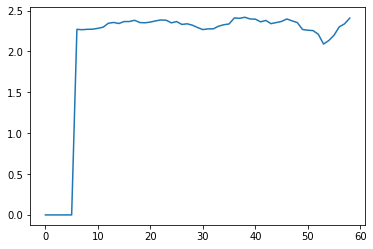

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,1,0.000000
0.0,2,0.000000
1.0,315885,2.651882


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (3, 2),
 'cluster_variance': 0.008172336258947012,
 'clustered_split_factor': 6,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff2a0dda340>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0,
 'split': 'browser',
 'split_variance': 0.00817233625894701}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


browser_clust    0
dtype: int64

browser_clust    44
dtype: int64

|X| (109, 2)
|--- value: [2.40]

Tree RPS MAE: 2.0728953355741053
|X| (66, 2)
|X| (32, 2)


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,315888,2.651857


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff29f984400>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0001155678206512612,
 'split': 'browser',
 'split_variance': 0.00817233625894701}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,1,0.000000
0.0,77645,2.527807
1.0,30580,2.996317
2.0,9,0.000000
3.0,67922,3.240017
4.0,131813,2.335786
5.0,7907,2.761537


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (7, 2),
 'cluster_variance': 0.36313301531981496,
 'clustered_split_factor': 10,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff29fb981c0>,
 'fit_shape': (7, 2),
 'rps_mae': 0.0,
 'split': 'operating_system',
 'split_variance': 0.36313301531981496}


operating_system    0
dtype: int64

operating_system    35
dtype: int64

|X| (360, 6)
|--- x0_Windows <= 0.50
|   |--- x0_Mac OS X <= 0.50
|   |   |--- x0_iOS <= 0.50
|   |   |   |--- x0_iPadOS <= 0.50
|   |   |   |   |--- value: [2.22]
|   |   |   |--- x0_iPadOS >  0.50
|   |   |   |   |--- value: [2.37]
|   |   |--- x0_iOS >  0.50
|   |   |   |--- value: [2.01]
|   |--- x0_Mac OS X >  0.50
|   |   |--- value: [2.75]
|--- x0_Windows >  0.50
|   |--- value: [3.03]

Tree RPS MAE: 0.3426829195522806
|X| (300, 6)
|X| (157, 6)


,sessions,rps
clust,,
4,77655,2.527482
5,7907,2.761537
6,131813,2.335786
7,30580,2.996317
8,67922,3.240017


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (5, 2),
 'cluster_variance': 0.36285441285470477,
 'clustered_split_factor': 5,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff29f6cca30>,
 'fit_shape': (7, 2),
 'rps_mae': 9.397648892903742e-05,
 'split': 'operating_system',
 'split_variance': 0.36313301531981496}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


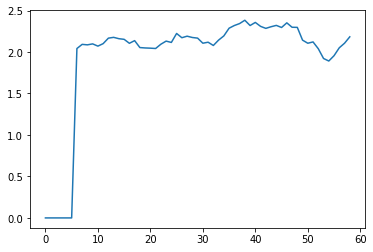

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,1,0.000000
0.0,77645,2.527807
1.0,30580,2.996317
2.0,9,0.000000
3.0,67922,3.240017
4.0,131813,2.335786
5.0,7907,2.761537


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (7, 2),
 'cluster_variance': 0.36313301531981496,
 'clustered_split_factor': 10,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff2a0e0ffa0>,
 'fit_shape': (7, 2),
 'rps_mae': 0.0,
 'split': 'operating_system',
 'split_variance': 0.36313301531981496}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


operating_system_clust    0
dtype: int64

operating_system_clust    35
dtype: int64

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (360, 6)
|--- x0_3.0 <= 0.50
|   |--- x0_1.0 <= 0.50
|   |   |--- x0_4.0 <= 0.50
|   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |--- value: [2.22]
|   |   |   |--- x0_5.0 >  0.50
|   |   |   |   |--- value: [2.37]
|   |   |--- x0_4.0 >  0.50
|   |   |   |--- value: [2.01]
|   |--- x0_1.0 >  0.50
|   |   |--- value: [2.75]
|--- x0_3.0 >  0.50
|   |--- value: [3.03]

Tree RPS MAE: 0.3426829195522805
|X| (300, 6)
|X| (157, 6)


,sessions,rps
clust,,
4,77655,2.527482
5,7907,2.761537
6,131813,2.335786
7,30580,2.996317
8,67922,3.240017


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (5, 2),
 'cluster_variance': 0.36285441285470477,
 'clustered_split_factor': 5,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff29f85a130>,
 'fit_shape': (7, 2),
 'rps_mae': 9.397648892903742e-05,
 'split': 'operating_system',
 'split_variance': 0.36313301531981496}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,102378,3.199149
1,202046,2.367826
2,11464,2.770193


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38624328254903945,
 'clustered_split_factor': 3,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff2a0c3a2b0>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0,
 'split': 'device',
 'split_variance': 0.38624328254903945}


device    0
dtype: int64

device    0
dtype: int64

|X| (195, 3)
|--- x0_DESK <= 0.50
|   |--- x0_PHON <= 0.50
|   |   |--- value: [2.48]
|   |--- x0_PHON >  0.50
|   |   |--- value: [2.05]
|--- x0_DESK >  0.50
|   |--- value: [2.96]

Tree RPS MAE: 0.12938432119517293
|X| (177, 3)
|X| (90, 3)


,sessions,rps
clust,,
2,11464,2.770193
3,202046,2.367826
4,102378,3.199149


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (3, 2),
 'cluster_variance': 0.3862432825490394,
 'clustered_split_factor': 3,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff29f9f4e80>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0,
 'split': 'device',
 'split_variance': 0.38624328254903945}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


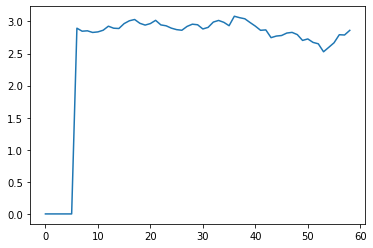

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,102378,3.199149
1,202046,2.367826
2,11464,2.770193


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38624328254903945,
 'clustered_split_factor': 3,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff29fc015e0>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0,
 'split': 'device',
 'split_variance': 0.38624328254903945}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


device_clust    0
dtype: int64

device_clust    0
dtype: int64

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (195, 3)
|--- x0_0.0 <= 0.50
|   |--- x0_1.0 <= 0.50
|   |   |--- value: [2.48]
|   |--- x0_1.0 >  0.50
|   |   |--- value: [2.05]
|--- x0_0.0 >  0.50
|   |--- value: [2.96]

Tree RPS MAE: 0.12938432119517293
|X| (177, 3)
|X| (90, 3)


,sessions,rps
clust,,
2,11464,2.770193
3,202046,2.367826
4,102378,3.199149


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (3, 2),
 'cluster_variance': 0.3862432825490394,
 'clustered_split_factor': 3,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff29fb985e0>,
 'fit_shape': (3, 2),
 'rps_mae': 0.0,
 'split': 'device',
 'split_variance': 0.38624328254903945}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,235123,2.590446
1,80765,2.830638


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (2, 2),
 'cluster_variance': 0.10478145898434366,
 'clustered_split_factor': 2,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff29f91bdf0>,
 'fit_shape': (2, 2),
 'rps_mae': 0.0,
 'split': 'product',
 'split_variance': 0.10478145898434366}


product    0
dtype: int64

product    0
dtype: int64

|X| (130, 2)
|--- x0_MEDICARE <= 0.50
|   |--- value: [2.28]
|--- x0_MEDICARE >  0.50
|   |--- value: [2.55]

Tree RPS MAE: 0.11228079358041583
|X| (118, 2)
|X| (60, 2)


,sessions,rps
clust,,
1,235123,2.590446
2,80765,2.830638


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (2, 2),
 'cluster_variance': 0.10478145898434366,
 'clustered_split_factor': 2,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff29f6c92b0>,
 'fit_shape': (2, 2),
 'rps_mae': 0.0,
 'split': 'product',
 'split_variance': 0.10478145898434366}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


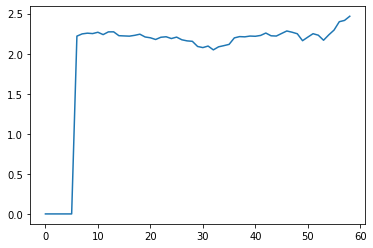

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,235123,2.590446
1,80765,2.830638


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (2, 2),
 'cluster_variance': 0.10478145898434366,
 'clustered_split_factor': 2,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff29f9e16d0>,
 'fit_shape': (2, 2),
 'rps_mae': 0.0,
 'split': 'product',
 'split_variance': 0.10478145898434366}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


product_clust    0
dtype: int64

product_clust    0
dtype: int64

|X| (130, 2)
|--- x0_1.0 <= 0.50
|   |--- value: [2.28]
|--- x0_1.0 >  0.50
|   |--- value: [2.55]

Tree RPS MAE: 0.11228079358041572
|X| (118, 2)
|X| (60, 2)


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
1,235123,2.590446
2,80765,2.830638


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (2, 2),
 'cluster_variance': 0.10478145898434366,
 'clustered_split_factor': 2,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff294e2e910>,
 'fit_shape': (2, 2),
 'rps_mae': 0.0,
 'split': 'product',
 'split_variance': 0.10478145898434366}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,3600,2.002723
1,18504,3.010000
2,2558,1.880651
3,5176,2.586287
4,5185,3.217852
...,...,...
59,2541,2.095499
60,1929,1.824144
61,4277,1.826184


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (64, 2),
 'cluster_variance': 0.5033225166270803,
 'clustered_split_factor': 295,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff294e30400>,
 'fit_shape': (672, 2),
 'rps_mae': 0.5035005459940368,
 'split': 'TOD',
 'split_variance': 0.7189835283121834}


dayofweek    0
hourofday    0
dtype: int64

dayofweek    0
hourofday    0
dtype: int64

|X| (39767, 103)
|--- x0_0.0 <= 0.50
|   |--- x0_6.0 <= 0.50
|   |   |--- x1_21.25 <= 0.50
|   |   |   |--- x1_20.5 <= 0.50
|   |   |   |   |--- x1_21.0 <= 0.50
|   |   |   |   |   |--- x1_21.5 <= 0.50
|   |   |   |   |   |   |--- x1_20.75 <= 0.50
|   |   |   |   |   |   |   |--- x1_11.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_10.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_15.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_11.5 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 35
|   |   |   |   |   |   |   |   |   |   |--- x1_11.5 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.96]
|   |   |   |   |   |   |   |   |   |--- x1_15.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [3.01]
|   |   |   |   |   |   |   |   |--- x1_10.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [3.01]
|   |   |   |   |   |   |   |--- x1_11.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [2.99]
|   | 

,sessions,rps
clust,,
45,16085,2.257571
46,20577,2.387243
47,16572,2.452364
48,19973,2.638397
49,2546,2.452614
50,3047,2.683181
51,3226,2.524449
52,3476,2.933333
53,3444,2.581143


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (46, 2),
 'cluster_variance': 0.46201676340604386,
 'clustered_split_factor': 195,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff29f2623d0>,
 'fit_shape': (672, 2),
 'rps_mae': 0.3912595460526522,
 'split': 'TOD',
 'split_variance': 0.7189835283121834}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


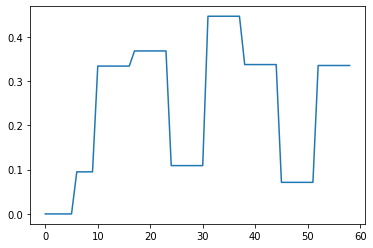

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,9180,1.822920
1,725,1.765672
2,8826,3.315216
3,165,2.736485
4,4990,2.464187
...,...,...
59,4689,2.631728
60,1113,2.381530
61,2035,2.048943


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (64, 2),
 'cluster_variance': 0.4922610816217411,
 'clustered_split_factor': 266,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff29f27f610>,
 'fit_shape': (672, 2),
 'rps_mae': 0.507726035787623,
 'split': 'TOD',
 'split_variance': 0.7189835283121834}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

dayofweek_clust    0
hourofday_clust    0
dtype: int64

dayofweek_clust    0
hourofday_clust    0
dtype: int64

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (26570, 71)
|--- x0_0.0 <= 0.50
|   |--- x0_6.0 <= 0.50
|   |   |--- x1_48.0 <= 0.50
|   |   |   |--- x1_22.0 <= 0.50
|   |   |   |   |--- x1_27.0 <= 0.50
|   |   |   |   |   |--- x1_21.0 <= 0.50
|   |   |   |   |   |   |--- x1_6.0 <= 0.50
|   |   |   |   |   |   |   |--- x1_51.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_50.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_20.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 18
|   |   |   |   |   |   |   |   |   |   |--- x1_4.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.94]
|   |   |   |   |   |   |   |   |   |--- x1_20.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_4.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- x0_4.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.38]
|   |   |   |   |  

,sessions,rps
clust,,
28,10811,2.055301
29,14146,2.187827
30,11862,2.236816
31,13488,2.271666
32,3427,2.470699
33,2541,2.878714
34,3767,2.730571
35,5024,2.545301
36,4956,2.592244


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (53, 2),
 'cluster_variance': 0.4899717764187475,
 'clustered_split_factor': 112,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff2a0e12670>,
 'fit_shape': (672, 2),
 'rps_mae': 0.5953910015381227,
 'split': 'TOD',
 'split_variance': 0.7189835283121834}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,28,1.148114
1,14694,2.968829
2,37728,1.917818
3,4913,2.281648
4,53,5.894340
...,...,...
59,858,4.685260
60,4973,2.677731
61,26412,2.846392


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (64, 2),
 'cluster_variance': 0.501383104147475,
 'clustered_split_factor': 64,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff2a0de4070>,
 'fit_shape': (210, 2),
 'rps_mae': 0.6910904720893402,
 'split': 'dma',
 'split_variance': 0.5611165541808859}


dma    0
dtype: int64

dma    626
dtype: int64

|X| (13610, 201)
|--- x0_501 <= 0.50
|   |--- x0_803 <= 0.50
|   |   |--- x0_506 <= 0.50
|   |   |   |--- x0_807 <= 0.50
|   |   |   |   |--- x0_819 <= 0.50
|   |   |   |   |   |--- x0_613 <= 0.50
|   |   |   |   |   |   |--- x0_528 <= 0.50
|   |   |   |   |   |   |   |--- x0_862 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_534 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_512 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_623 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 23
|   |   |   |   |   |   |   |   |   |   |--- x0_623 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.91]
|   |   |   |   |   |   |   |   |   |--- x0_512 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [3.33]
|   |   |   |   |   |   |   |   |--- x0_534 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [1.97]
|   |   |   |   |   |   |   |--- x0_862 >  0.50
|   |   |   |   |   |   |   |   |--- value: [1.61]
|   |   |   |   |   |

,sessions,rps
clust,,
33,109923,2.743451
34,3349,3.170211
35,4953,2.622863
36,3406,3.151003
37,3520,2.816415
38,5187,2.647071
39,11772,2.623287
40,2907,2.682253
41,3723,2.870844


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (34, 2),
 'cluster_variance': 0.40725919112598696,
 'clustered_split_factor': 34,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff29f7cfdc0>,
 'fit_shape': (210, 2),
 'rps_mae': 0.5497379733024856,
 'split': 'dma',
 'split_variance': 0.5611165541808859}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


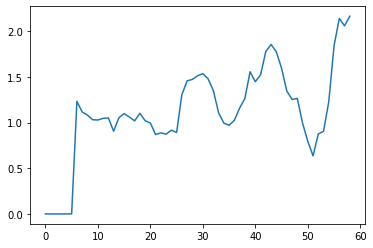

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,7306,2.820257
1,93,1.800430
2,538,3.354597
3,14683,2.339709
4,26,1.236430
...,...,...
59,163,2.717362
60,17362,3.036158
61,4089,3.120049


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (64, 2),
 'cluster_variance': 0.4722866451779828,
 'clustered_split_factor': 64,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff29f594a00>,
 'fit_shape': (210, 2),
 'rps_mae': 0.7417294549972074,
 'split': 'dma',
 'split_variance': 0.5611165541808859}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


dma_clust    0
dtype: int64

dma_clust    374
dtype: int64

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (4132, 59)
|--- x0_36.0 <= 0.50
|   |--- x0_44.0 <= 0.50
|   |   |--- x0_0.0 <= 0.50
|   |   |   |--- x0_35.0 <= 0.50
|   |   |   |   |--- x0_21.0 <= 0.50
|   |   |   |   |   |--- x0_9.0 <= 0.50
|   |   |   |   |   |   |--- x0_38.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_30.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_14.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_31.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_57.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- x0_57.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.72]
|   |   |   |   |   |   |   |   |   |--- x0_31.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [3.16]
|   |   |   |   |   |   |   |   |--- x0_14.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.90]
|   |   |   |   |   |   |   |--- x0_30.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [2.83]
|   |   | 

,sessions,rps
clust,,
20,17844,2.617615
21,4624,2.842953
22,7306,2.820257
23,22489,2.623691
24,6305,3.050300
25,4484,2.751267
26,14855,2.489079
27,2349,1.909221
28,7030,2.690619


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (21, 2),
 'cluster_variance': 0.4416618006043587,
 'clustered_split_factor': 21,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff29f8e9b80>,
 'fit_shape': (210, 2),
 'rps_mae': 0.7945035848154185,
 'split': 'dma',
 'split_variance': 0.5611165541808859}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,421,1.287359
1,4728,3.401156
2,3008,2.909479
3,5925,2.592757
4,29399,1.892818
5,7309,3.486085
6,2217,1.683636
7,1873,2.598122
8,1034,3.860861


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (51, 2),
 'cluster_variance': 0.5137811273822879,
 'clustered_split_factor': 51,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff29f7c4f40>,
 'fit_shape': (51, 2),
 'rps_mae': 0.0,
 'split': 'state',
 'split_variance': 0.5137811273822879}


state    0
dtype: int64

state    0
dtype: int64

|X| (3315, 51)
|--- x0_NY <= 0.50
|   |--- x0_CA <= 0.50
|   |   |--- x0_MA <= 0.50
|   |   |   |--- x0_FL <= 0.50
|   |   |   |   |--- x0_NJ <= 0.50
|   |   |   |   |   |--- x0_WA <= 0.50
|   |   |   |   |   |   |--- x0_MN <= 0.50
|   |   |   |   |   |   |   |--- x0_CT <= 0.50
|   |   |   |   |   |   |   |   |--- x0_MD <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_OR <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_PA <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 25
|   |   |   |   |   |   |   |   |   |   |--- x0_PA >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.41]
|   |   |   |   |   |   |   |   |   |--- x0_OR >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.21]
|   |   |   |   |   |   |   |   |--- x0_MD >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [3.15]
|   |   |   |   |   |   |   |--- x0_CT >  0.50
|   |   |   |   |   |   |   |   |--- value: [1.29]
|   |   |   |   |   |   |--- x0_MN >  

,sessions,rps
clust,,
35,16241,2.410724
36,3766,2.705449
37,6736,2.739866
38,3595,3.240519
39,8031,2.639474
40,13666,2.609931
41,3121,2.702654
42,9592,2.681652
43,4900,2.948056


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (36, 2),
 'cluster_variance': 0.4761876448226851,
 'clustered_split_factor': 36,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff29c106e80>,
 'fit_shape': (51, 2),
 'rps_mae': 0.0640643813175297,
 'split': 'state',
 'split_variance': 0.5137811273822879}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


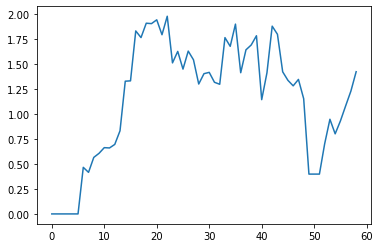

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,421,1.287359
1,4728,3.401156
2,3008,2.909479
3,5925,2.592757
4,29399,1.892818
5,7309,3.486085
6,2217,1.683636
7,1873,2.598122
8,1034,3.860861


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (51, 2),
 'cluster_variance': 0.5137811273822879,
 'clustered_split_factor': 51,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff2a0de4490>,
 'fit_shape': (51, 2),
 'rps_mae': 0.0,
 'split': 'state',
 'split_variance': 0.5137811273822879}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust    0
dtype: int64

state_clust    0
dtype: int64

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (3315, 51)
|--- x0_34.0 <= 0.50
|   |--- x0_4.0 <= 0.50
|   |   |--- x0_19.0 <= 0.50
|   |   |   |--- x0_9.0 <= 0.50
|   |   |   |   |--- x0_31.0 <= 0.50
|   |   |   |   |   |--- x0_47.0 <= 0.50
|   |   |   |   |   |   |--- x0_23.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_20.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_37.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_38.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 25
|   |   |   |   |   |   |   |   |   |   |--- x0_38.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.41]
|   |   |   |   |   |   |   |   |   |--- x0_37.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.21]
|   |   |   |   |   |   |   |   |--- x0_20.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [3.15]
|   |   |   |   |   |   |   |--- x0_6.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [1.29]
|   |   |   

,sessions,rps
clust,,
35,16241,2.410724
36,3766,2.705449
37,6736,2.739866
38,3595,3.240519
39,8031,2.639474
40,13666,2.609931
41,3121,2.702654
42,9592,2.681652
43,4900,2.948056


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (36, 2),
 'cluster_variance': 0.4761876448226851,
 'clustered_split_factor': 36,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff2fac8f8e0>,
 'fit_shape': (51, 2),
 'rps_mae': 0.0640643813175297,
 'split': 'state',
 'split_variance': 0.5137811273822879}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,11,0.544545
0.0,90,3.872556
1.0,21077,2.655257
2.0,409,2.596230
3.0,1,0.000000
...,...,...
59.0,43,1.416744
60.0,46,3.907826
61.0,6760,3.136014


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (65, 2),
 'cluster_variance': 0.4678428010243888,
 'clustered_split_factor': 326,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff2a0d464c0>,
 'fit_shape': (366, 2),
 'rps_mae': 0.8553418718577634,
 'split': 'location',
 'split_variance': 0.6266786684873187}


state    0
dma      0
dtype: int64

state      0
dma      677
dtype: int64

|X| (22082, 252)
|--- x1_501 <= 0.50
|   |--- x0_CA <= 0.50
|   |   |--- x0_MA <= 0.50
|   |   |   |--- x0_FL <= 0.50
|   |   |   |   |--- x0_WA <= 0.50
|   |   |   |   |   |--- x0_MN <= 0.50
|   |   |   |   |   |   |--- x0_MD <= 0.50
|   |   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |   |--- x0_VA <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_TX <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_CO <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 24
|   |   |   |   |   |   |   |   |   |   |--- x0_CO >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.90]
|   |   |   |   |   |   |   |   |   |--- x0_TX >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_641 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- x1_641 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.53]
|   |   |   |   |   |   |   |   |--- x

,sessions,rps
clust,,
34,18585,2.280660
35,3136,2.570681
36,3766,2.705449
38,3583,2.635939
39,3153,2.857966
41,6418,2.753312
42,6649,2.604818
43,3595,3.240519
44,3121,2.702654


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (59, 2),
 'cluster_variance': 0.4804914006195786,
 'clustered_split_factor': 83,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff29f90b760>,
 'fit_shape': (366, 2),
 'rps_mae': 0.6034561844336311,
 'split': 'location',
 'split_variance': 0.6266786684873187}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


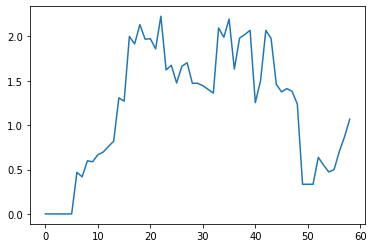

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,11,0.544545
0.0,11674,1.985837
1.0,52,0.958077
2.0,599,2.037356
3.0,61519,2.768893
...,...,...
59.0,44,1.534545
60.0,58,1.864655
61.0,9031,2.748372


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (65, 2),
 'cluster_variance': 0.44295841879144227,
 'clustered_split_factor': 329,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff2a0df7850>,
 'fit_shape': (366, 2),
 'rps_mae': 0.8892038435711607,
 'split': 'location',
 'split_variance': 0.6266786684873187}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

state_clust    0
dma_clust      0
dtype: int64

state_clust      0
dma_clust      425
dtype: int64

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (19825, 110)
|--- x1_26.0 <= 0.50
|   |--- x1_42.0 <= 0.50
|   |   |--- x0_9.0 <= 0.50
|   |   |   |--- x0_4.0 <= 0.50
|   |   |   |   |--- x0_47.0 <= 0.50
|   |   |   |   |   |--- x0_20.0 <= 0.50
|   |   |   |   |   |   |--- x1_44.0 <= 0.50
|   |   |   |   |   |   |   |--- x1_9.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_41.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_10.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_27.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- x1_27.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [3.03]
|   |   |   |   |   |   |   |   |   |--- x1_10.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [3.23]
|   |   |   |   |   |   |   |   |--- x1_41.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- x0_15.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_43.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |-

,sessions,rps
clust,,
21,20406,2.493238
22,4057,2.279042
23,3831,2.768777
27,4373,2.758974
28,3160,2.853616
29,5085,2.772381
30,3649,1.940990
31,6296,2.587586
32,3064,3.089623


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (49, 2),
 'cluster_variance': 0.4603733407289256,
 'clustered_split_factor': 205,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff29f90bbb0>,
 'fit_shape': (366, 2),
 'rps_mae': 0.6665667956321358,
 'split': 'location',
 'split_variance': 0.6266786684873187}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,10,0.000000
0.0,13572,2.481786
1.0,3418,1.753076
3.0,573,2.018636
4.0,2953,2.765432
...,...,...
59.0,1967,3.212799
60.0,461,2.354280
61.0,16358,2.907775


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (64, 2),
 'cluster_variance': 0.5427657043714813,
 'clustered_split_factor': 241,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff294eb6640>,
 'fit_shape': (1043, 2),
 'rps_mae': 1.4839735530725702,
 'split': 'dma_os',
 'split_variance': 0.8930874246798637}


dma                 0
operating_system    0
dtype: int64

dma                 1931
operating_system      35
dtype: int64

|X| (64299, 207)
|--- x1_Windows <= 0.50
|   |--- x1_Mac OS X <= 0.50
|   |   |--- x0_501 <= 0.50
|   |   |   |--- x0_506 <= 0.50
|   |   |   |   |--- x0_524 <= 0.50
|   |   |   |   |   |--- x0_803 <= 0.50
|   |   |   |   |   |   |--- x1_iOS <= 0.50
|   |   |   |   |   |   |   |--- x0_618 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_623 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_iPadOS <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_602 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.23]
|   |   |   |   |   |   |   |   |   |   |--- x0_602 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.27]
|   |   |   |   |   |   |   |   |   |--- x1_iPadOS >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.42]
|   |   |   |   |   |   |   |   |--- x0_623 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.57]
|   |   |   |   |   |   |   |--- x0_618 >  0.50
|   |   |   |   |   |   |   |   |--- value: [2.74]
|   |   |   |   |   |

,sessions,rps
clust,,
11,57730,2.509100
12,3307,2.451092
13,6505,2.825459
14,4068,3.027960
15,3525,2.896550
24,76339,2.428678
25,4766,2.293887
26,5017,2.516904
27,5418,2.629079


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (27, 2),
 'cluster_variance': 0.45332052645976945,
 'clustered_split_factor': 39,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff2a0df0a60>,
 'fit_shape': (1043, 2),
 'rps_mae': 1.4417680546295546,
 'split': 'dma_os',
 'split_variance': 0.8930874246798637}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


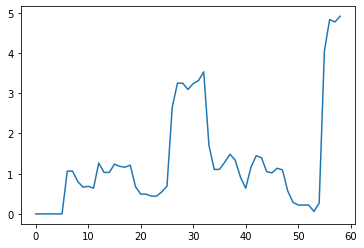

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,10,0.000000
0.0,158,1.432225
1.0,3084,2.611164
2.0,148,1.552178
3.0,13871,3.436893
...,...,...
59.0,470,2.622536
60.0,3860,2.093588
61.0,1408,2.474970


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (65, 2),
 'cluster_variance': 0.47310102758110134,
 'clustered_split_factor': 279,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff2a0df0700>,
 'fit_shape': (1043, 2),
 'rps_mae': 1.4997737593818914,
 'split': 'dma_os',
 'split_variance': 0.8930874246798637}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)


dma_clust                 0
operating_system_clust    0
dtype: int64

dma_clust                 1029
operating_system_clust      35
dtype: int64

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (19038, 65)
|--- x1_3.0 <= 0.50
|   |--- x0_53.0 <= 0.50
|   |   |--- x1_1.0 <= 0.50
|   |   |   |--- x0_48.0 <= 0.50
|   |   |   |   |--- x0_50.0 <= 0.50
|   |   |   |   |   |--- x0_44.0 <= 0.50
|   |   |   |   |   |   |--- x0_39.0 <= 0.50
|   |   |   |   |   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_9.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_30.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_5.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- x1_5.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.56]
|   |   |   |   |   |   |   |   |   |--- x0_30.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.67]
|   |   |   |   |   |   |   |   |--- x0_9.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [1.76]
|   |   |   |   |   |   |   |--- x1_4.0 >  0.50
|   |   |   |   |   |   |   |   |--- x0_27.0 <= 0.50
|   |   |   | 

,sessions,rps
clust,,
17,20333,2.579695
18,3579,2.356142
19,3541,2.316052
20,7031,2.634797
21,5348,2.629733
22,6439,2.898262
23,2917,2.760907
24,5099,2.935357
25,6546,2.856357


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (44, 2),
 'cluster_variance': 0.5255240889826265,
 'clustered_split_factor': 59,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff2a0eb04f0>,
 'fit_shape': (1043, 2),
 'rps_mae': 1.4672235833144107,
 'split': 'dma_os',
 'split_variance': 0.8930874246798637}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0.0,5965,1.968882
1.0,37732,2.601862
2.0,762,2.020403
3.0,1,0.000000
4.0,3617,2.571652
...,...,...
59.0,18435,3.408209
60.0,128,2.855869
61.0,607,3.437799


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (64, 2),
 'cluster_variance': 0.610117399018545,
 'clustered_split_factor': 134,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff2a0e050a0>,
 'fit_shape': (625, 2),
 'rps_mae': 1.1538407503482342,
 'split': 'dma_device',
 'split_variance': 0.8184746864952386}


dma       0
device    0
dtype: int64

dma       1310
device       0
dtype: int64

|X| (39064, 204)
|--- x1_DESK <= 0.50
|   |--- x0_501 <= 0.50
|   |   |--- x0_506 <= 0.50
|   |   |   |--- x0_524 <= 0.50
|   |   |   |   |--- x1_PHON <= 0.50
|   |   |   |   |   |--- value: [2.54]
|   |   |   |   |--- x1_PHON >  0.50
|   |   |   |   |   |--- x0_623 <= 0.50
|   |   |   |   |   |   |--- x0_803 <= 0.50
|   |   |   |   |   |   |   |--- x0_807 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_751 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_618 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_819 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- x0_819 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.72]
|   |   |   |   |   |   |   |   |   |--- x0_618 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.42]
|   |   |   |   |   |   |   |   |--- x0_751 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.58]
|   |   |   |   |   |   |   |--- x0_807 > 

,sessions,rps
clust,,
5,10543,2.790026
21,98707,2.430477
22,4241,2.443509
23,2823,1.946234
24,7876,2.360802
25,7406,2.528052
26,3228,2.334329
27,3742,2.424724
28,4187,2.309309


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (31, 2),
 'cluster_variance': 0.5159997182947648,
 'clustered_split_factor': 34,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff33601fc10>,
 'fit_shape': (625, 2),
 'rps_mae': 1.0493510363462661,
 'split': 'dma_device',
 'split_variance': 0.8184746864952386}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


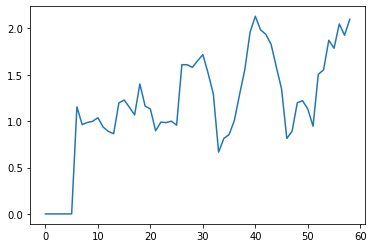

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0.0,3868,2.181631
1.0,228,2.795589
2.0,12606,3.508369
3.0,576,2.966179
4.0,55,2.058015
...,...,...
59.0,959,4.421094
60.0,136,3.499071
61.0,36116,2.774149


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (64, 2),
 'cluster_variance': 0.5596494206040468,
 'clustered_split_factor': 146,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff33601f8e0>,
 'fit_shape': (625, 2),
 'rps_mae': 1.1793867283646278,
 'split': 'dma_device',
 'split_variance': 0.8184746864952386}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)


dma_clust       0
device_clust    0
dtype: int64

dma_clust       726
device_clust      0
dtype: int64

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (11582, 62)
|--- x1_0.0 <= 0.50
|   |--- x0_35.0 <= 0.50
|   |   |--- x0_30.0 <= 0.50
|   |   |   |--- x0_15.0 <= 0.50
|   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |--- value: [2.55]
|   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |--- x0_22.0 <= 0.50
|   |   |   |   |   |   |--- x0_54.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_60.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_50.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_56.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_45.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- x0_45.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.91]
|   |   |   |   |   |   |   |   |   |--- x0_56.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.76]
|   |   |   |   |   |   |   |   |--- x0_50.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [1.68]
|   |   |   |   |   |   |   |--- x

,sessions,rps
clust,,
5,9789,2.827019
21,26725,2.312691
22,3568,2.290512
23,10206,2.788935
24,14651,2.467060
25,4641,2.608740
26,11696,2.530516
27,26185,2.454637
28,5944,2.565091


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (39, 2),
 'cluster_variance': 0.5677299113052625,
 'clustered_split_factor': 42,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff2a0df4130>,
 'fit_shape': (625, 2),
 'rps_mae': 1.1465625683109342,
 'split': 'dma_device',
 'split_variance': 0.8184746864952386}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,172,3.267733
0.0,1290,2.363997
1.0,3155,3.313130
2.0,2,0.000000
3.0,5,7.824000
...,...,...
59.0,1321,3.947305
60.0,1304,2.240439
61.0,3681,1.571046


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (63, 2),
 'cluster_variance': 0.530772303614138,
 'clustered_split_factor': 381,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff2a0e92be0>,
 'fit_shape': (1849, 2),
 'rps_mae': 1.5793182050046286,
 'split': 'dma_os_device',
 'split_variance': 1.0776399186248111}


dma                 0
operating_system    0
device              0
dtype: int64

dma                 2071
operating_system      35
device                 0
dtype: int64

|X| (91995, 210)
|--- x2_DESK <= 0.50
|   |--- x0_501 <= 0.50
|   |   |--- x0_506 <= 0.50
|   |   |   |--- x0_524 <= 0.50
|   |   |   |   |--- x2_TBLT <= 0.50
|   |   |   |   |   |--- x0_623 <= 0.50
|   |   |   |   |   |   |--- x0_803 <= 0.50
|   |   |   |   |   |   |   |--- x0_807 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_751 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_618 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_819 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |   |--- x0_819 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.72]
|   |   |   |   |   |   |   |   |   |--- x0_618 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_iOS <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.66]
|   |   |   |   |   |   |   |   |   |   |--- x1_iOS >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.26]
|   |   |   |   |   |   |   |   |--- x0

,sessions,rps
clust,,
17,42113,2.432937
18,3116,2.462620
21,69278,2.409723
22,4760,2.294150
23,5008,2.520190
24,3742,2.424724
25,4187,2.309309
26,6151,2.164611
27,3039,2.269688


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (34, 2),
 'cluster_variance': 0.516829645222512,
 'clustered_split_factor': 127,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff2ef7f28e0>,
 'fit_shape': (1849, 2),
 'rps_mae': 1.5177347066676983,
 'split': 'dma_os_device',
 'split_variance': 1.0776399186248111}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


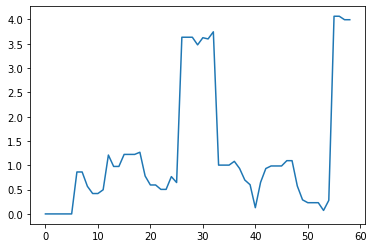

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,172,3.267733
0.0,142,1.528044
1.0,800,2.486448
2.0,717,2.700434
3.0,31015,2.826911
...,...,...
59.0,488,2.659466
60.0,681,2.003140
61.0,808,2.785055


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (65, 2),
 'cluster_variance': 0.4629224183184351,
 'clustered_split_factor': 454,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff2a0e0ff70>,
 'fit_shape': (1849, 2),
 'rps_mae': 1.5894997064236454,
 'split': 'dma_os_device',
 'split_variance': 1.0776399186248111}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)


dma_clust                 0
operating_system_clust    0
device_clust              0
dtype: int64

dma_clust                 1072
operating_system_clust      35
device_clust                 0
dtype: int64

|X| (30462, 68)
|--- x2_0.0 <= 0.50
|   |--- x0_33.0 <= 0.50
|   |   |--- x0_25.0 <= 0.50
|   |   |   |--- x0_56.0 <= 0.50
|   |   |   |   |--- x2_1.0 <= 0.50
|   |   |   |   |   |--- x1_0.0 <= 0.50
|   |   |   |   |   |   |--- value: [2.46]
|   |   |   |   |   |--- x1_0.0 >  0.50
|   |   |   |   |   |   |--- value: [2.91]
|   |   |   |   |--- x2_1.0 >  0.50
|   |   |   |   |   |--- x0_58.0 <= 0.50
|   |   |   |   |   |   |--- x0_1.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_46.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_31.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_42.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_55.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |   |--- x0_55.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.52]
|   |   |   |   |   |   |   |   |   |--- x0_42.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_0.0 <= 0.50
|   |   |   |   

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
6,7232,2.757052
7,2558,2.937791
20,14025,2.448483
21,3535,2.298809
22,5536,2.606454
23,4155,2.392382
24,6070,2.475726
25,7610,2.679195
32,22417,2.371151


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (48, 2),
 'cluster_variance': 0.5787355724982649,
 'clustered_split_factor': 154,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff2ef7b07c0>,
 'fit_shape': (1849, 2),
 'rps_mae': 1.5450663629010057,
 'split': 'dma_os_device',
 'split_variance': 1.0776399186248111}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,10,0.000000
0.0,9574,3.242824
1.0,5523,1.766396
2.0,4821,2.877245
3.0,686,1.604339
...,...,...
59.0,1009,3.216680
60.0,4855,2.446793
61.0,15078,2.631175


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6173851703978319,
 'clustered_split_factor': 145,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff294e12ca0>,
 'fit_shape': (262, 2),
 'rps_mae': 0.8150973672137521,
 'split': 'state_os',
 'split_variance': 0.7018905076318772}


state               0
operating_system    0
dtype: int64

state                0
operating_system    35
dtype: int64

|X| (16556, 57)
|--- x1_Windows <= 0.50
|   |--- x1_Mac OS X <= 0.50
|   |   |--- x0_NY <= 0.50
|   |   |   |--- x0_CA <= 0.50
|   |   |   |   |--- x0_MA <= 0.50
|   |   |   |   |   |--- x0_NJ <= 0.50
|   |   |   |   |   |   |--- x0_FL <= 0.50
|   |   |   |   |   |   |   |--- x0_MN <= 0.50
|   |   |   |   |   |   |   |   |--- x0_WA <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_iOS <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- x0_GA >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.80]
|   |   |   |   |   |   |   |   |   |--- x1_iOS >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- x0_GA >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.63]
|   |   |   |   |   |   |   |

,sessions,rps
clust,,
17,33011,2.589056
18,3355,2.634350
19,3140,2.567812
20,3854,2.484109
21,2423,2.513652
22,10175,2.954670
23,5632,3.030317
24,4780,3.202020
36,34280,2.376316


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (44, 2),
 'cluster_variance': 0.5294185021416349,
 'clustered_split_factor': 64,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff2a0e0f8e0>,
 'fit_shape': (262, 2),
 'rps_mae': 0.6838640975372544,
 'split': 'state_os',
 'split_variance': 0.7018905076318772}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


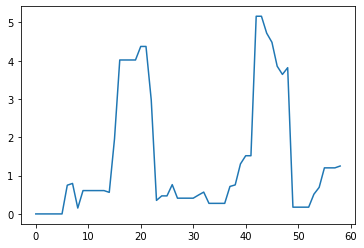

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,10,0.000000
0.0,3448,3.001679
1.0,378,2.538946
2.0,17905,3.653020
4.0,5464,1.553593
...,...,...
59.0,26,2.216154
60.0,47,2.112966
61.0,44,4.369979


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (64, 2),
 'cluster_variance': 0.5826232442057593,
 'clustered_split_factor': 137,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff2a0df0130>,
 'fit_shape': (262, 2),
 'rps_mae': 0.8631459325550281,
 'split': 'state_os',
 'split_variance': 0.7018905076318772}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust               0
operating_system_clust    0
dtype: int64

state_clust                0
operating_system_clust    35
dtype: int64

|X| (16556, 57)
|--- x1_3.0 <= 0.50
|   |--- x1_1.0 <= 0.50
|   |   |--- x0_34.0 <= 0.50
|   |   |   |--- x0_4.0 <= 0.50
|   |   |   |   |--- x0_19.0 <= 0.50
|   |   |   |   |   |--- x0_31.0 <= 0.50
|   |   |   |   |   |   |--- x0_9.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_23.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_47.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_10.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- x0_10.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.80]
|   |   |   |   |   |   |   |   |   |--- x1_4.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_10.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |   |--- x0_10.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.63]
|   |   |   |   | 

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
17,33011,2.589056
18,3355,2.634350
19,3140,2.567812
20,3854,2.484109
21,2423,2.513652
22,10175,2.954670
23,5632,3.030317
24,4780,3.202020
36,34280,2.376316


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (44, 2),
 'cluster_variance': 0.5294185021416349,
 'clustered_split_factor': 64,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff2a0e0fa30>,
 'fit_shape': (262, 2),
 'rps_mae': 0.6838640975372544,
 'split': 'state_os',
 'split_variance': 0.7018905076318772}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,14937,2.663950
1,2159,1.502927
2,10643,3.363312
3,864,2.788143
4,244,0.988952
...,...,...
59,20425,1.755479
60,544,3.431573
61,2950,1.414749


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6395836103132039,
 'clustered_split_factor': 82,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff2a0de6e80>,
 'fit_shape': (153, 2),
 'rps_mae': 0.5517102001411325,
 'split': 'state_device',
 'split_variance': 0.6988164231749556}


state     0
device    0
dtype: int64

state     0
device    0
dtype: int64

|X| (9918, 54)
|--- x1_DESK <= 0.50
|   |--- x0_NY <= 0.50
|   |   |--- x0_CA <= 0.50
|   |   |   |--- x0_MA <= 0.50
|   |   |   |   |--- x0_NJ <= 0.50
|   |   |   |   |   |--- x1_PHON <= 0.50
|   |   |   |   |   |   |--- value: [2.66]
|   |   |   |   |   |--- x1_PHON >  0.50
|   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |--- x0_MN <= 0.50
|   |   |   |   |   |   |   |   |--- x0_TX <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_WA <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_FL <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 18
|   |   |   |   |   |   |   |   |   |   |--- x0_FL >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.88]
|   |   |   |   |   |   |   |   |   |--- x0_WA >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.69]
|   |   |   |   |   |   |   |   |--- x0_TX >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.41]
|   |   |   |   |   |   |   |--- x0_MN >  0.50
|

,sessions,rps
clust,,
6,9970,2.943968
29,28592,2.328420
30,8026,2.293520
31,3334,1.886173
32,5544,2.482033
33,9011,2.353340
34,4436,2.338373
35,5462,2.444473
36,2581,2.703144


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (45, 2),
 'cluster_variance': 0.592355576413342,
 'clustered_split_factor': 49,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff28c59f1f0>,
 'fit_shape': (153, 2),
 'rps_mae': 0.36485628332239184,
 'split': 'state_device',
 'split_variance': 0.6988164231749556}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


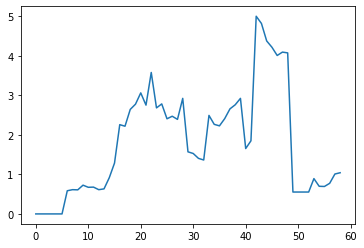

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,22,5.020000
1,46800,2.623871
2,4245,1.425248
3,3801,3.603715
4,11866,3.493796
...,...,...
59,106,4.373901
60,4518,1.658180
61,5021,1.606820


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6169660082461268,
 'clustered_split_factor': 78,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff2a0cf2340>,
 'fit_shape': (153, 2),
 'rps_mae': 0.5847873467502122,
 'split': 'state_device',
 'split_variance': 0.6988164231749556}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust     0
device_clust    0
dtype: int64

state_clust     0
device_clust    0
dtype: int64

|X| (9918, 54)
|--- x1_0.0 <= 0.50
|   |--- x0_34.0 <= 0.50
|   |   |--- x0_4.0 <= 0.50
|   |   |   |--- x0_19.0 <= 0.50
|   |   |   |   |--- x0_31.0 <= 0.50
|   |   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |   |--- value: [2.66]
|   |   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |   |--- x0_10.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_23.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_43.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_47.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_9.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 18
|   |   |   |   |   |   |   |   |   |   |--- x0_9.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.88]
|   |   |   |   |   |   |   |   |   |--- x0_47.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.69]
|   |   |   |   |   |   |   |   |--- x0_43.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.41]
|   |   |   |   |   |   |   |-

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
6,9970,2.943968
29,28592,2.328420
30,8026,2.293520
31,3334,1.886173
32,5544,2.482033
33,9011,2.353340
34,4436,2.338373
35,5462,2.444473
36,2581,2.703144


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (45, 2),
 'cluster_variance': 0.592355576413342,
 'clustered_split_factor': 49,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff29f9e59a0>,
 'fit_shape': (153, 2),
 'rps_mae': 0.36485628332239184,
 'split': 'state_device',
 'split_variance': 0.6988164231749556}


/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,62,2.375711
0.0,1910,1.897343
2.0,22090,2.674060
3.0,245,2.676163
4.0,3,0.000000
...,...,...
59.0,1113,2.888071
60.0,1373,3.531806
61.0,10,1.368000


{'clust_mtd': 'AggRPSClust64',
 'clust_shape': (63, 2),
 'cluster_variance': 0.6115507766796318,
 'clustered_split_factor': 254,
 'clusterer': <models.utils.rpc_est.AggRPSClust object at 0x7ff294e97f40>,
 'fit_shape': (586, 2),
 'rps_mae': 0.9590782870242622,
 'split': 'state_os_device',
 'split_variance': 0.8017208423785755}


state               0
operating_system    0
device              0
dtype: int64

state                0
operating_system    35
device               0
dtype: int64

|X| (29377, 60)
|--- x2_DESK <= 0.50
|   |--- x0_NY <= 0.50
|   |   |--- x0_CA <= 0.50
|   |   |   |--- x0_MA <= 0.50
|   |   |   |   |--- x0_NJ <= 0.50
|   |   |   |   |   |--- x2_TBLT <= 0.50
|   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |--- x0_MN <= 0.50
|   |   |   |   |   |   |   |   |--- x0_TX <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_WA <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_FL <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- x0_FL >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- x0_WA >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.69]
|   |   |   |   |   |   |   |   |--- x0_TX >  0.50
|   |   |   |   |   |   |   |   |   |--- x1_iOS <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.52]
|   |   |   |   |   |   |   |   |   |--- x1_iOS >  0.50
|

,sessions,rps
clust,,
18,28024,2.440929
19,3615,2.440096
25,32480,2.404285
26,5396,2.295219
27,3284,2.495204
28,3434,2.622684
29,3436,2.499941
30,5236,2.232737
32,3058,2.536103


{'clust_mtd': 'TreeRPSClust64',
 'clust_shape': (47, 2),
 'cluster_variance': 0.5757894613037846,
 'clustered_split_factor': 161,
 'clusterer': <models.utils.rpc_est.TreeRPSClust object at 0x7ff29f27fe20>,
 'fit_shape': (586, 2),
 'rps_mae': 0.7812824075742719,
 'split': 'state_os_device',
 'split_variance': 0.8017208423785755}


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


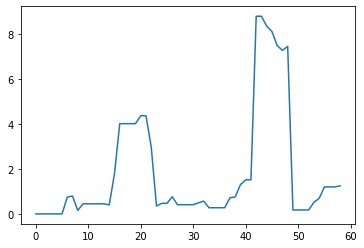

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
-1.0,62,2.375711
0.0,4092,2.002591
1.0,33,4.933333
2.0,3519,2.210100
3.0,161,0.672422
...,...,...
59.0,25,2.097234
60.0,56,2.181729
61.0,922,2.333413


{'clust_mtd': 'KpiSimClust64',
 'clust_shape': (65, 2),
 'cluster_variance': 0.5932716006010051,
 'clustered_split_factor': 255,
 'clusterer': <models.utils.rpc_est.KpiSimClust object at 0x7ff294eb6f70>,
 'fit_shape': (586, 2),
 'rps_mae': 0.9810275375073736,
 'split': 'state_os_device',
 'split_variance': 0.8017208423785755}


<ipython-input-16-9f82cc8dd923>:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust               0
operating_system_clust    0
device_clust              0
dtype: int64

state_clust                0
operating_system_clust    35
device_clust               0
dtype: int64

|X| (29377, 60)
|--- x2_0.0 <= 0.50
|   |--- x0_34.0 <= 0.50
|   |   |--- x0_4.0 <= 0.50
|   |   |   |--- x0_19.0 <= 0.50
|   |   |   |   |--- x0_31.0 <= 0.50
|   |   |   |   |   |--- x2_2.0 <= 0.50
|   |   |   |   |   |   |--- x0_10.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_23.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_43.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_47.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_9.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- x0_9.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- x0_47.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.69]
|   |   |   |   |   |   |   |   |--- x0_43.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.52]
|   |   |   |   |   |   |   |   |   |-

/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
/home/amal/Dropbox/Documents/hc/adtech/models/utils/rpc_est.py:275: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
18,28024,2.440929
19,3615,2.440096
25,32480,2.404285
26,5396,2.295219
27,3284,2.495204
28,3434,2.622684
29,3436,2.499941
30,5236,2.232737
32,3058,2.536103


{'clust_mtd': 'HybridCorrTreeClust64',
 'clust_shape': (47, 2),
 'cluster_variance': 0.5757894613037846,
 'clustered_split_factor': 161,
 'clusterer': <models.utils.rpc_est.HybridCorrTreeClust object at 0x7ff2a0fe20a0>,
 'fit_shape': (586, 2),
 'rps_mae': 0.7812824075742719,
 'split': 'state_os_device',
 'split_variance': 0.8017208423785755}


,clust_mtd,clusterer,split,fit_shape,clust_shape,split_variance,cluster_variance,clustered_split_factor,rps_mae
0,AggRPSClust64,<models.utils.rpc_est.AggRPSClust object at 0x...,browser,"(3, 2)","(3, 2)",0.008172,0.008172,6,0.000000
1,TreeRPSClust64,<models.utils.rpc_est.TreeRPSClust object at 0...,browser,"(3, 2)","(1, 2)",0.008172,0.000000,1,0.000116
2,KpiSimClust64,<models.utils.rpc_est.KpiSimClust object at 0x...,browser,"(3, 2)","(3, 2)",0.008172,0.008172,6,0.000000
3,HybridCorrTreeClust64,<models.utils.rpc_est.HybridCorrTreeClust obje...,browser,"(3, 2)","(1, 2)",0.008172,0.000000,1,0.000116
4,AggRPSClust64,<models.utils.rpc_est.AggRPSClust object at 0x...,operating_system,"(7, 2)","(7, 2)",0.363133,0.363133,10,0.000000
5,TreeRPSClust64,<models.utils.rpc_est.TreeRPSClust object at 0...,operating_system,"(7, 2)","(5, 2)",0.363133,0.362854,5,0.000094
6,KpiSimClust64,<models.utils.rpc_est.KpiSimClust object at 0x...,operating_system,"(7, 2)","(7, 2)",0.363133,0.363133,10,0.000000
7,HybridCorrTreeClust64,<models.utils.rpc_est.HybridCorrTreeClust obje...,operating_system,"(7, 2)","(5, 2)",0.363133,0.362854,5,0.000094
8,AggRPSClust64,<models.utils.rpc_est.AggRPSClust object at 0x...,device,"(3, 2)","(3, 2)",0.386243,0.386243,3,0.000000
9,TreeRPSClust64,<models.utils.rpc_est.TreeRPSClust object at 0...,device,"(3, 2)","(3, 2)",0.386243,0.386243,3,0.000000


In [16]:
import importlib
import models.utils.rpc_est
from models.utils.rpc_est import get_split_factor
importlib.reload(models.utils.rpc_est)
AggRPSClust = models.utils.rpc_est.AggRPSClust
TreeRPSClust = models.utils.rpc_est.TreeRPSClust
KpiSimClust = models.utils.rpc_est.KpiSimClust
HybridCorrTreeClust = models.utils.rpc_est.HybridCorrTreeClust

def AggRPSClust64(): return AggRPSClust(clusts=64)
def TreeRPSClust64(): return TreeRPSClust(clusts=64)
def KpiSimClust64(): return KpiSimClust(clusts=64)
def HybridCorrTreeClust64(): return HybridCorrTreeClust(clusts=64)
MTDS = [
    AggRPSClust64,
    TreeRPSClust64,
    KpiSimClust64,
    HybridCorrTreeClust64,
]

perfD = []
for split,rps_df in [*split2aggrps.items()]:
    
    rps_df["lps"] = rps_df["num_leads"] / rps_df["sessions"]
    rps_df["rpl"] = rps_df["revenue"] / rps_df["num_leads"]
    rps_df["score"] = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
    rps_df["rps"] = rps_df["rps_avg"]
    fitI = rps_df.reset_index()['utc_dt'].dt.date < eval_date
    fitI.index = rps_df.index

    for clust_mtd in MTDS:
        clusterer = clust_mtd().fit(rps_df[fitI],None)
        rps_df["clust"] = -1
        rps_df.loc[fitI,"clust"] = clusterer.transform(rps_df[fitI])
        rps_df.loc[~fitI,"clust"] = clusterer.transform(rps_df[~fitI])
        rps_df["clust"] = rps_df["clust"].fillna(-1)
        rps_df["rps_clust"] = rps_df \
            .groupby(["clust","utc_dt"]) \
            ["rps"].transform(get_wavg_by(rps_df,"sessions"))
        daily_rps_mae = (rps_df["rps"] - rps_df["rps_clust"]).abs()
            
        agg_rps_df = rps_df \
            [~fitI] \
            .groupby(rps_df.index.names[:-1]) \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(rps_df[~fitI],"sessions")
            })
        clust_rps_df = rps_df \
            [~fitI] \
            .groupby("clust") \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(rps_df[~fitI],"sessions")
            })
        ipydisp(clust_rps_df)
        assert clust_rps_df["rps"].max() <= agg_rps_df["rps"].max()
        rps_wavg = wavg(agg_rps_df[["rps"]], agg_rps_df["sessions"])
        rps_clust_wavg = wavg(clust_rps_df[["rps"]], clust_rps_df["sessions"])
        assert all((rps_wavg - rps_clust_wavg).abs() < 1e-2), (rps_wavg, rps_clust_wavg)        
        
        perfd = {
            "clust_mtd": clust_mtd.__name__,
            "clusterer": clusterer,
            "split": split,
            "fit_shape": agg_rps_df.shape,
            "clust_shape": clust_rps_df.shape,
            "split_variance": wstd(agg_rps_df["rps"], agg_rps_df["sessions"]),
            "cluster_variance": wstd(clust_rps_df["rps"], clust_rps_df["sessions"]),
            # wstd(rps_df["rps_avg"],rps_df["sessions"])
            "clustered_split_factor": get_split_factor(rps_df),
            "rps_mae": wavg(daily_rps_mae,rps_df["sessions"]),
        }
        perfD.append(perfd)
        pprint.pprint(perfd)

perfdf = pd.DataFrame(perfD)
ipydisp(perfdf)

In [17]:
perfdf.tail(50)

,clust_mtd,clusterer,split,fit_shape,clust_shape,split_variance,cluster_variance,clustered_split_factor,rps_mae
6,KpiSimClust64,<models.utils.rpc_est.KpiSimClust object at 0x...,operating_system,"(7, 2)","(7, 2)",0.363133,0.363133,10,0.000000
7,HybridCorrTreeClust64,<models.utils.rpc_est.HybridCorrTreeClust obje...,operating_system,"(7, 2)","(5, 2)",0.363133,0.362854,5,0.000094
8,AggRPSClust64,<models.utils.rpc_est.AggRPSClust object at 0x...,device,"(3, 2)","(3, 2)",0.386243,0.386243,3,0.000000
9,TreeRPSClust64,<models.utils.rpc_est.TreeRPSClust object at 0...,device,"(3, 2)","(3, 2)",0.386243,0.386243,3,0.000000
10,KpiSimClust64,<models.utils.rpc_est.KpiSimClust object at 0x...,device,"(3, 2)","(3, 2)",0.386243,0.386243,3,0.000000
11,HybridCorrTreeClust64,<models.utils.rpc_est.HybridCorrTreeClust obje...,device,"(3, 2)","(3, 2)",0.386243,0.386243,3,0.000000
12,AggRPSClust64,<models.utils.rpc_est.AggRPSClust object at 0x...,product,"(2, 2)","(2, 2)",0.104781,0.104781,2,0.000000
13,TreeRPSClust64,<models.utils.rpc_est.TreeRPSClust object at 0...,product,"(2, 2)","(2, 2)",0.104781,0.104781,2,0.000000
14,KpiSimClust64,<models.utils.rpc_est.KpiSimClust object at 0x...,product,"(2, 2)","(2, 2)",0.104781,0.104781,2,0.000000
15,HybridCorrTreeClust64,<models.utils.rpc_est.HybridCorrTreeClust obje...,product,"(2, 2)","(2, 2)",0.104781,0.104781,2,0.000000


In [144]:
import sklearn.tree
print(sklearn.tree.export_text(clusterer.clf, feature_names=clusterer.enc_features))


|--- x1_DESK <= 0.50
|   |--- x0_NY <= 0.50
|   |   |--- x0_CA <= 0.50
|   |   |   |--- x0_MA <= 0.50
|   |   |   |   |--- x0_NJ <= 0.50
|   |   |   |   |   |--- x1_PHON <= 0.50
|   |   |   |   |   |   |--- value: [2.66]
|   |   |   |   |   |--- x1_PHON >  0.50
|   |   |   |   |   |   |--- x0_GA <= 0.50
|   |   |   |   |   |   |   |--- x0_MN <= 0.50
|   |   |   |   |   |   |   |   |--- x0_TX <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_WA <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_FL <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 18
|   |   |   |   |   |   |   |   |   |   |--- x0_FL >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.88]
|   |   |   |   |   |   |   |   |   |--- x0_WA >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.69]
|   |   |   |   |   |   |   |   |--- x0_TX >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.41]
|   |   |   |   |   |   |   |--- x0_MN >  0.50
|   |   |   |   

In [26]:
split,clusterer = perfdf.loc[49,["split","clusterer"]]
print("split:",split)
rps_df = split2aggrps[split]
rps_df["lps"] = rps_df["num_leads"] / rps_df["sessions"]
rps_df["rpl"] = rps_df["revenue"] / rps_df["num_leads"]
rps_df["score"] = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
rps_df["rps"] = rps_df["rps_avg"]
fitI = rps_df.reset_index()['utc_dt'].dt.date < eval_date
fitI.index = rps_df.index

rps_df["clust"] = -1
rps_df.loc[fitI,"clust"] = clusterer.transform(rps_df[fitI])
rps_df.loc[~fitI,"clust"] = clusterer.transform(rps_df[~fitI])

split_attr2unique_vals = {index_col: rps_df.index.unique(index_col) 
                          for index_col in rps_df.index.names[:-1]}
_,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
rps_df = rps_df.reset_index()
campaign_df = rps_df \
    .groupby([*new_index_order[:-1], "clust"]) \
    .agg({
        "sessions": sum,
        "rps_avg": get_wavg_by(rps_df,"sessions"),
        new_index_order[-1]: lambda seq: tuple(set(seq))
    }) \
    .sort_index()

assert campaign_df["sessions"].sum() == rps_df["sessions"].sum()
camp_rps_wavg = wavg(campaign_df["rps_avg"],campaign_df["sessions"])
fit_rps_wavg = wavg(rps_df["rps_avg"], rps_df["sessions"])
assert abs(camp_rps_wavg - fit_rps_wavg) < 1e-5

split: state_device
|X| (8718, 54)
|X| (4402, 54)


In [136]:
camps = []
thresh = max(campaign_df["sessions"].sum() / 3000,100)
for idx,r in campaign_df[campaign_df["sessions"] > thresh].iterrows():
    camp = {
        "sessions_60d": r["sessions"], 
        "rps_avg_60d": r["rps_avg"]
    }
    for field,val in zip(new_index_order[:-1],idx):
        camp[field] = {"INCLUDE": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "INCLUDE": r[last_field]
    }
    camps.append(camp)

excl_campaign_df = campaign_df.groupby([*new_index_order[:-1]]) \
    .agg({
        new_index_order[-1]: tuple
    })
def flatten(M):
    return tuple(el for r in M for el in r)
excl_campaign_df[new_index_order[-1]] = excl_campaign_df[new_index_order[-1]] \
    .apply(flatten)
for idx, r in excl_campaign_df.iterrows():
    camp = {}
    idx = tuple(idx) if isinstance(idx,(tuple,list,set)) else [idx]
    for field, val in zip(new_index_order[:-1], idx):
        camp[field] = {"INCLUDE": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "EXCLUDE": r[last_field]
    }
    camps.append(camp)

camp_targeting_df = pd.DataFrame(camps)
camp_targeting_df.to_csv(f"[{traffic_source}]_<{split}>_campaign_targeting.csv")
camp_targeting_df

# TODO: 
# - only do this if os is not already in the split
camp_targeting_df["operating_system"] = None
# def yield_os_targeting_df():
#     for os in TABOOLA_OS_DOMAIN:
#         camp_targeting_df["operating_system"] = camp_targeting_df["operating_system"] \
#             .map(lambda _: {"INCLUDE": os})
#         yield camp_targeting_df
device2os = {
    'DESK': ['Mac_OS_X', 'Linux', 'Windows'],
    'PHON': ['iOS', 'Android'],
    'TBLT': ['iPadOS','Android'],
}
def yield_os_targeting_df():
    for device,osseq in device2os.items():
        devI = device == \
            camp_targeting_df["device"] \
                .apply(lambda d: [*d.values()][0])
        for os in osseq:
            camp_targeting_df["operating_system"] = \
                camp_targeting_df["operating_system"] \
                    .map(lambda _: {"INCLUDE": os})
            yield camp_targeting_df[devI]
camp_targeting_df = pd.concat(yield_os_targeting_df(),)
camp_targeting_df = camp_targeting_df.reset_index(drop=True)
camp_targeting_df["created"] = False
camp_targeting_df['id'] = np.NaN
camp_targeting_df.to_csv(f"_.csv")

In [66]:
import json

TABOOLA_HC_CREDS = json.loads(os.getenv("TABOOLA_HC_CREDS"))
TABOOLA_PIVOT_CREDS = json.loads(os.getenv("TABOOLA_PIVOT_CREDS"))
TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"

from pytaboola import TaboolaClient
client = TaboolaClient(**TABOOLA_HC_CREDS)

from pytaboola.services import AccountService
from pytaboola.services import CampaignService

acct_service = AccountService(client)
accnts = acct_service.list()["results"]
NETWORK_ACCNT_ID = "healthcareinc-network"
TEST_ACCNT_ID = "healthcareinc-sc2"
O65_ACCNT_ID = "taboolaaccount-rangaritahealthcarecom"
id2accnt = {a["account_id"]: a for a in accnts}

def accnt_camps(accnt):
    camp_service = CampaignService(client, accnt["account_id"])
    return camp_service.list()
aid2cid2camp = {}
for aid,a in tqdm.tqdm(id2accnt.items()):
    cid2camp = {c["id"]: c for c in accnt_camps(a)}
    aid2cid2camp[aid] = cid2camp

import json
json.dump(aid2cid2camp, open("camps.json", "w"))
O65_accnt_camps = accnt_camps(id2accnt[O65_ACCNT_ID])
print("|065_accnt_camps|:",len(O65_accnt_camps))

test_accnt_camps = accnt_camps(id2accnt[TEST_ACCNT_ID])
print("|test_accnt_camps|",len(test_accnt_camps))

import itertools
cross = itertools.product
import jmespath
get = jmespath.search

active_camps = get(
  "*.*[] | [?is_active]",
  aid2cid2camp,
)
print("|active campaigns|:",len(active_camps))

100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


|065_accnt_camps|: 103
|test_accnt_camps| 12
|active campaigns|: 4


In [ ]:
def taboola_targetting_fields(r):
    def pivot(o):
        (t,v),*_ = o.items()
        return {
            "type": t,
            "value": [*v] if isinstance(v,(list,tuple,set)) else [v]
        }
    targetting_fields = {}
    if "device" in r:
        targetting_fields["platform_targeting"] = pivot(r["device"])
    if "state" in r:
        targetting_fields["sub_country_targeting"] = pivot(r["state"])
    if "dma" in r:
        targetting_fields["dma_country_targeting"] = pivot(r["dma"])
    if "operating_system" in r:
        (t,v),*_ = r["operating_system"].items()
        targetting_fields["os_targeting"] = {
            "type": "INCLUDE",
            "value": [
                {
                    "os_family": v
                },
            ],
        }
    return targetting_fields
ipydisp(camp_attr_df.apply(taboola_targetting_fields,axis=1).head())
taboola_targetting_fields(camp_targeting_df.iloc[0,:])

TOTAL_BUDGET = 500
DEFAULT_CPC = 1.00
campaign_daily_budget = max(30.,TOTAL_BUDGET / len(camp_targeting_df))
campaign_daily_budget = np.round(campaign_daily_budget,2)
print("campaign_daily_budget:",campaign_daily_budget)
def get_base_campaign(name):
    campaign_json = {
        "name": name,
        "branding_text": "HealthCare.com",
        "tracking_code": (
            "SRC=720&"
            "utm_medium=native&"
            "utm_source=taboola&"
            f"utm_campaign={name}&"
            "utm_content={campaign_item_id}&"
            "cpc={cpc}&"
            "ts={timestamp}"
            "&utm_term={site}&"
            "iv=__iv_p_17_a_{campaign_id}_pi_{site_id}_d_{platform}_se_{site}_f_{campaign_item_id}_z_3_vi__"
        ),
        "pricing_model": "CPC",
        "cpc": DEFAULT_CPC,
        "daily_cap": campaign_daily_budget,
        "daily_ad_delivery_model": "STRICT",
        "spending_limit": 100000.,
        "spending_limit_model": "ENTIRE",
        "bid_type": "FIXED",
        "marketing_objective": "LEADS_GENERATION",
        "country_targeting": {
            "type": "INCLUDE",
            "value": ["US"],
        },
        "is_active": False,
    }
    return campaign_json

In [146]:
1/0
dest_accnt = id2accnt[TEST_ACCNT_ID]

for i in tqdm.tqdm(range(len(camp_targeting_df))):
    if camp_targeting_df.loc[i,"created"]: continue
    campaign_json = {
    #     **get_base_campaign(f"[{traffic_source}]_<{split}>_campaign_0"),
        **get_base_campaign(f"Prospecting_Desktop_RON_Attic_{i}"),
        **taboola_targetting_fields(camp_targeting_df.iloc[i]),
    }

    client = TaboolaClient(**TABOOLA_HC_CREDS)
    resp = requests.post(
        f"{TABOOLA_BASE}/{dest_accnt['account_id']}/campaigns",
        json=campaign_json,
        headers=client.authorization_header,)
    resp.raise_for_status()

    new_camp = resp.json()
    print("created new camp w/ id:",new_camp["id"])
    camp_targeting_df.loc[i,["created","id"]] = [True,new_camp["id"]]
    

camp_targeting_df.to_csv(rscfn(__name__,f"active_campaigns.csv"))

  4%|▍         | 5/122 [00:03<01:18,  1.49it/s]

created new camp w/ id: 11502747


  5%|▍         | 6/122 [00:05<02:02,  1.05s/it]

created new camp w/ id: 11502748


  6%|▌         | 7/122 [00:08<02:38,  1.37s/it]

created new camp w/ id: 11502749


  7%|▋         | 8/122 [00:09<02:48,  1.48s/it]

created new camp w/ id: 11502750


  7%|▋         | 9/122 [00:11<02:55,  1.55s/it]

created new camp w/ id: 11502751


  8%|▊         | 10/122 [00:13<03:02,  1.63s/it]

created new camp w/ id: 11502752


  9%|▉         | 11/122 [00:16<03:34,  1.93s/it]

created new camp w/ id: 11502753


 10%|▉         | 12/122 [00:18<03:41,  2.01s/it]

created new camp w/ id: 11502755


 11%|█         | 13/122 [00:20<03:56,  2.17s/it]

created new camp w/ id: 11502756


 11%|█▏        | 14/122 [00:23<04:00,  2.23s/it]

created new camp w/ id: 11502757


 12%|█▏        | 15/122 [00:26<04:24,  2.47s/it]

created new camp w/ id: 11502759


 13%|█▎        | 16/122 [00:28<04:15,  2.41s/it]

created new camp w/ id: 11502760


 14%|█▍        | 17/122 [00:30<03:58,  2.27s/it]

created new camp w/ id: 11502763


 15%|█▍        | 18/122 [00:32<03:49,  2.21s/it]

created new camp w/ id: 11502764


 16%|█▌        | 19/122 [00:35<03:53,  2.27s/it]

created new camp w/ id: 11502766


 16%|█▋        | 20/122 [00:37<03:45,  2.21s/it]

created new camp w/ id: 11502767


 17%|█▋        | 21/122 [00:39<03:57,  2.35s/it]

created new camp w/ id: 11502768


 18%|█▊        | 22/122 [00:42<03:52,  2.32s/it]

created new camp w/ id: 11502770


 19%|█▉        | 23/122 [00:44<03:47,  2.30s/it]

created new camp w/ id: 11502771


 20%|█▉        | 24/122 [00:46<03:47,  2.32s/it]

created new camp w/ id: 11502773


 20%|██        | 25/122 [00:48<03:42,  2.30s/it]

created new camp w/ id: 11502776


 21%|██▏       | 26/122 [00:51<03:56,  2.47s/it]

created new camp w/ id: 11502777


 22%|██▏       | 27/122 [00:55<04:18,  2.72s/it]

created new camp w/ id: 11502778


 23%|██▎       | 28/122 [00:57<04:12,  2.68s/it]

created new camp w/ id: 11502779


 24%|██▍       | 29/122 [01:00<04:09,  2.69s/it]

created new camp w/ id: 11502781


 25%|██▍       | 30/122 [01:02<03:46,  2.47s/it]

created new camp w/ id: 11502782


 25%|██▌       | 31/122 [01:06<04:17,  2.83s/it]

created new camp w/ id: 11502783


 26%|██▌       | 32/122 [01:08<03:58,  2.65s/it]

created new camp w/ id: 11502784


 27%|██▋       | 33/122 [01:12<04:27,  3.01s/it]

created new camp w/ id: 11502786


 28%|██▊       | 34/122 [01:14<04:08,  2.82s/it]

created new camp w/ id: 11502787


 29%|██▊       | 35/122 [01:16<03:52,  2.67s/it]

created new camp w/ id: 11502788


 30%|██▉       | 36/122 [01:19<03:52,  2.71s/it]

created new camp w/ id: 11502789


 30%|███       | 37/122 [01:21<03:26,  2.42s/it]

created new camp w/ id: 11502790


 31%|███       | 38/122 [01:28<05:25,  3.88s/it]

created new camp w/ id: 11502792


 32%|███▏      | 39/122 [01:30<04:27,  3.22s/it]

created new camp w/ id: 11502793


 33%|███▎      | 40/122 [01:32<04:00,  2.93s/it]

created new camp w/ id: 11502794


 34%|███▎      | 41/122 [01:34<03:31,  2.61s/it]

created new camp w/ id: 11502795


 34%|███▍      | 42/122 [01:36<03:13,  2.42s/it]

created new camp w/ id: 11502796


 35%|███▌      | 43/122 [01:37<02:49,  2.14s/it]

created new camp w/ id: 11502797


 36%|███▌      | 44/122 [01:40<02:52,  2.21s/it]

created new camp w/ id: 11502798


 37%|███▋      | 45/122 [01:42<02:52,  2.24s/it]

created new camp w/ id: 11502799


 38%|███▊      | 46/122 [01:49<04:38,  3.67s/it]

created new camp w/ id: 11502801


 39%|███▊      | 47/122 [01:52<04:19,  3.46s/it]

created new camp w/ id: 11502802


 39%|███▉      | 48/122 [01:54<03:50,  3.11s/it]

created new camp w/ id: 11502803


 40%|████      | 49/122 [01:56<03:18,  2.72s/it]

created new camp w/ id: 11502805


 41%|████      | 50/122 [01:58<03:07,  2.60s/it]

created new camp w/ id: 11502806


 42%|████▏     | 51/122 [02:01<02:53,  2.44s/it]

created new camp w/ id: 11502808


 43%|████▎     | 52/122 [02:03<02:42,  2.32s/it]

created new camp w/ id: 11502809


 43%|████▎     | 53/122 [02:05<02:43,  2.36s/it]

created new camp w/ id: 11502810


 44%|████▍     | 54/122 [02:07<02:38,  2.33s/it]

created new camp w/ id: 11502812


 45%|████▌     | 55/122 [02:09<02:28,  2.22s/it]

created new camp w/ id: 11502813


 46%|████▌     | 56/122 [02:13<02:47,  2.54s/it]

created new camp w/ id: 11502815


 47%|████▋     | 57/122 [02:15<02:40,  2.47s/it]

created new camp w/ id: 11502816


 48%|████▊     | 58/122 [02:18<02:41,  2.53s/it]

created new camp w/ id: 11502818


 48%|████▊     | 59/122 [02:20<02:41,  2.56s/it]

created new camp w/ id: 11502819


 49%|████▉     | 60/122 [02:29<04:30,  4.36s/it]

created new camp w/ id: 11502821


 50%|█████     | 61/122 [02:31<03:50,  3.78s/it]

created new camp w/ id: 11502822


 51%|█████     | 62/122 [02:33<03:14,  3.25s/it]

created new camp w/ id: 11502823


 52%|█████▏    | 63/122 [02:36<02:56,  2.98s/it]

created new camp w/ id: 11502824


 52%|█████▏    | 64/122 [02:39<02:56,  3.04s/it]

created new camp w/ id: 11502825


 53%|█████▎    | 65/122 [02:41<02:39,  2.81s/it]

created new camp w/ id: 11502826


 54%|█████▍    | 66/122 [02:44<02:33,  2.74s/it]

created new camp w/ id: 11502827


 55%|█████▍    | 67/122 [02:46<02:33,  2.78s/it]

created new camp w/ id: 11502828


 56%|█████▌    | 68/122 [02:51<03:03,  3.39s/it]

created new camp w/ id: 11502829


 57%|█████▋    | 69/122 [02:54<02:52,  3.26s/it]

created new camp w/ id: 11502830


 57%|█████▋    | 70/122 [02:56<02:31,  2.90s/it]

created new camp w/ id: 11502832


 58%|█████▊    | 71/122 [02:59<02:21,  2.77s/it]

created new camp w/ id: 11502833


 59%|█████▉    | 72/122 [03:00<02:00,  2.40s/it]

created new camp w/ id: 11502835


 60%|█████▉    | 73/122 [03:02<01:53,  2.32s/it]

created new camp w/ id: 11502836


 61%|██████    | 74/122 [03:04<01:44,  2.18s/it]

created new camp w/ id: 11502838


 61%|██████▏   | 75/122 [03:07<01:44,  2.22s/it]

created new camp w/ id: 11502839


 62%|██████▏   | 76/122 [03:09<01:44,  2.27s/it]

created new camp w/ id: 11502840


 63%|██████▎   | 77/122 [03:11<01:43,  2.31s/it]

created new camp w/ id: 11502842


 64%|██████▍   | 78/122 [03:14<01:44,  2.38s/it]

created new camp w/ id: 11502843


 65%|██████▍   | 79/122 [03:16<01:39,  2.30s/it]

created new camp w/ id: 11502845


 66%|██████▌   | 80/122 [03:18<01:29,  2.14s/it]

created new camp w/ id: 11502846


 66%|██████▋   | 81/122 [03:20<01:31,  2.23s/it]

created new camp w/ id: 11502848


 67%|██████▋   | 82/122 [03:22<01:29,  2.24s/it]

created new camp w/ id: 11502849


 68%|██████▊   | 83/122 [03:25<01:30,  2.31s/it]

created new camp w/ id: 11502850


 69%|██████▉   | 84/122 [03:27<01:26,  2.28s/it]

created new camp w/ id: 11502851


 70%|██████▉   | 85/122 [03:31<01:42,  2.77s/it]

created new camp w/ id: 11502852


 70%|███████   | 86/122 [03:33<01:33,  2.61s/it]

created new camp w/ id: 11502854


 71%|███████▏  | 87/122 [03:36<01:30,  2.59s/it]

created new camp w/ id: 11502855


 72%|███████▏  | 88/122 [03:38<01:24,  2.49s/it]

created new camp w/ id: 11502856


 73%|███████▎  | 89/122 [03:41<01:22,  2.51s/it]

created new camp w/ id: 11502857


 74%|███████▍  | 90/122 [03:43<01:20,  2.50s/it]

created new camp w/ id: 11502858


 75%|███████▍  | 91/122 [03:46<01:19,  2.55s/it]

created new camp w/ id: 11502859


 75%|███████▌  | 92/122 [03:48<01:13,  2.44s/it]

created new camp w/ id: 11502860


 76%|███████▌  | 93/122 [03:50<01:05,  2.25s/it]

created new camp w/ id: 11502861


 77%|███████▋  | 94/122 [03:52<01:02,  2.22s/it]

created new camp w/ id: 11502862


 78%|███████▊  | 95/122 [03:54<01:00,  2.23s/it]

created new camp w/ id: 11502864


 79%|███████▊  | 96/122 [03:56<00:56,  2.19s/it]

created new camp w/ id: 11502865


 80%|███████▉  | 97/122 [03:58<00:54,  2.16s/it]

created new camp w/ id: 11502866


 80%|████████  | 98/122 [04:01<00:52,  2.19s/it]

created new camp w/ id: 11502867


 81%|████████  | 99/122 [04:03<00:52,  2.28s/it]

created new camp w/ id: 11502869


 82%|████████▏ | 100/122 [04:05<00:50,  2.30s/it]

created new camp w/ id: 11502870


 83%|████████▎ | 101/122 [04:08<00:48,  2.29s/it]

created new camp w/ id: 11502873


 84%|████████▎ | 102/122 [04:10<00:43,  2.16s/it]

created new camp w/ id: 11502874


 84%|████████▍ | 103/122 [04:11<00:37,  1.96s/it]

created new camp w/ id: 11502875


 85%|████████▌ | 104/122 [04:14<00:38,  2.15s/it]

created new camp w/ id: 11502877


 86%|████████▌ | 105/122 [04:16<00:36,  2.16s/it]

created new camp w/ id: 11502878


 87%|████████▋ | 106/122 [04:18<00:35,  2.20s/it]

created new camp w/ id: 11502880


 88%|████████▊ | 107/122 [04:21<00:34,  2.28s/it]

created new camp w/ id: 11502881


 89%|████████▊ | 108/122 [04:23<00:30,  2.17s/it]

created new camp w/ id: 11502883


 89%|████████▉ | 109/122 [04:25<00:28,  2.20s/it]

created new camp w/ id: 11502884


 90%|█████████ | 110/122 [04:27<00:25,  2.12s/it]

created new camp w/ id: 11502886


 91%|█████████ | 111/122 [04:29<00:22,  2.04s/it]

created new camp w/ id: 11502888


 92%|█████████▏| 112/122 [04:31<00:20,  2.03s/it]

created new camp w/ id: 11502889


 93%|█████████▎| 113/122 [04:33<00:18,  2.05s/it]

created new camp w/ id: 11502890


 93%|█████████▎| 114/122 [04:35<00:15,  1.99s/it]

created new camp w/ id: 11502891


 94%|█████████▍| 115/122 [04:37<00:14,  2.06s/it]

created new camp w/ id: 11502892


 95%|█████████▌| 116/122 [04:39<00:12,  2.16s/it]

created new camp w/ id: 11502893


 96%|█████████▌| 117/122 [04:42<00:11,  2.34s/it]

created new camp w/ id: 11502894


 97%|█████████▋| 118/122 [04:44<00:09,  2.28s/it]

created new camp w/ id: 11502895


 98%|█████████▊| 119/122 [04:46<00:06,  2.24s/it]

created new camp w/ id: 11502897


 98%|█████████▊| 120/122 [04:48<00:04,  2.22s/it]

created new camp w/ id: 11502898


 99%|█████████▉| 121/122 [04:51<00:02,  2.20s/it]

created new camp w/ id: 11502899


100%|██████████| 122/122 [04:53<00:00,  2.41s/it]

created new camp w/ id: 11502900


In [ ]:
resp = requests.post(
    f"{TABOOLA_BASE}/{dest_accnt['account_id']}/campaigns/bulk-update", 
    json={
        "campaigns": camp_targeting_df["id"].tolist(),
        "update": {
            "is_active": False
        }
    }, 
    headers=client.authorization_header)
resp.raise_for_status()
resp.json()

In [ ]:
1/0
dest_accnt = id2accnt[TEST_ACCNT_ID]
i = 0
campaign_json = {
#     **get_base_campaign(f"[{traffic_source}]_<{split}>_campaign_0"),
    **get_base_campaign(f"prospecting_desktop_ron_attic_{i}"),
    **taboola_targetting_fields(camp_targeting_df.iloc[i]),
}
print(json.dumps(campaign_json,indent=2))

client = TaboolaClient(**TABOOLA_HC_CREDS)
resp = requests.post(
    f"{TABOOLA_BASE}/{dest_accnt['account_id']}/campaigns",
    json=campaign_json,
    params= {
        "destination_account": dest_accnt["account_id"],
    },
    headers=client.authorization_header,)
resp.raise_for_status()

new_camp = resp.json()

new_camp

In [269]:
src_accnt = id2accnt[O65_ACCNT_ID]
src_camp = active_camps[0]
dest_accnt = id2accnt[TEST_ACCNT_ID]

client = TaboolaClient(**TABOOLA_HC_CREDS)
client.authorization_header,client.token_details

resp = requests.post(
    f"{TABOOLA_BASE}/{src_accnt['account_id']}/campaigns/{src_camp['id']}/duplicate",
    json={
        "name": src_camp["id"],
        "start_date": (TODAY + 2*DAY).__str__(),
        **taboola_targetting_fields(camp_attr_df.iloc[0]),
    },
    params= {
        "destination_account": dest_accnt["account_id"],
    },
    headers=client.authorization_header,)
resp.raise_for_status()

new_camp = resp.json()

HTTPError: 400 Client Error: Bad Request for url: https://backstage.taboola.com/backstage/api/1.0/taboolaaccount-rangaritahealthcarecom/campaigns/10798231/duplicate?destination_account=healthcareinc-sc2

In [ ]:
# import requests
# TODAY = NOW.date()
# TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"
# for src_camp in active_camps:
#     src_accnt = id2accnt[O65_ACCNT_ID]
#     dest_accnt = id2accnt[TEST_ACCNT_ID]

#     client = TaboolaClient(**TABOOLA_HC_CREDS)
#     client.authorization_header,client.token_details

#     for _,camp_attrs in camp_attr_df.iterrows():
#         resp = requests.post(
#             f"{TABOOLA_BASE}/{src_accnt['account_id']}/campaigns/{src_camp['id']}/duplicate",
#             json={
#                 "name": src_camp["id"],
#                 "start_date": (TODAY + 2*DAY).__str__(),
#                 **taboola_targetting_fields(camp_attrs),
#             },
#             params= {
#                 "destination_account": dest_accnt["account_id"],
#             },
#             headers=client.authorization_header,)
#         resp.raise_for_status()

#         new_camp = resp.json()

In [34]:
import json
TABOOLA_HC_CREDS = json.loads(os.getenv("TABOOLA_HC_CREDS"))
TABOOLA_PIVOT_CREDS = json.loads(os.getenv("TABOOLA_PIVOT_CREDS"))

from pytaboola import TaboolaClient
client = TaboolaClient(**TABOOLA_HC_CREDS)
client.token_details

import requests
import jmespath
TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"
resp = requests.get(
    f"{TABOOLA_BASE}/resources/campaigns_properties/operating_systems",
    headers=client.authorization_header)
taboola_os = jmespath.search('results[].name',resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/campaigns_properties/platforms",
    headers=client.authorization_header)
taboola_platforms = jmespath.search('results[].name', resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/countries/us/dma",
    headers=client.authorization_header)
taboola_dmas = jmespath.search('results[].name',resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/countries/us/regions",
    headers=client.authorization_header)
taboola_states = jmespath.search('results[].name',resp.json(),)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.feature_selection
import sklearn.metrics
from matplotlib import pyplot as plt
import sklearn.preprocessing

requires_campaign_split = [
    # "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]

for split in requires_campaign_split:
    rps_df = split2aggrps[split] .reset_index()
    Xs = rps_df \
        .apply(lambda r: [r["int_ix"]]*int(r["sessions"]), axis=1)
    X = np.concatenate(Xs.values).reshape(-1,1)
    ys = rps_df \
        .apply(lambda r: [r["rps_avg"]]*int(r["sessions"]),axis=1)
    y = np.concatenate(ys.values)
    # print(y.min(),np.quantile(y, 0.5),y.max())
    y = y > y.mean()
    # y = np.concatenate(ys.values).reshape(-1,1)
    # y = sklearn.preprocessing.KBinsDiscretizer(n_bins=2,encode="ordinal") \
    #     .fit_transform(y).reshape(-1)
    mi = sklearn.feature_selection.mutual_info_regression(X,y,discrete_features=True)
    print(split,mi,y.mean(),rps_df.shape)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt

requires_campaign_split = [
    "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]
combined_rps_df = pd.concat([df.reset_index() for df in split2aggrps.values()])
splitI = combined_rps_df["split_on"].isin(requires_campaign_split)
density = scipy.stats.gaussian_kde(
    dataset=combined_rps_df.loc[splitI,"rps_avg"],
    weights=combined_rps_df.loc[splitI, "sessions"],
    # bw_method="scott",
    # bw_method="silverman",
    # bw_method=0.1,
)
xs = np.linspace(0,2,100)
plt.plot(xs,density(xs))

In [ ]:
for split in requires_campaign_split:
    splitI = combined_rps_df["split_on"] == split
    density = scipy.stats.gaussian_kde(
        dataset=combined_rps_df.loc[splitI, "rps_avg"],
        weights=combined_rps_df.loc[splitI, "sessions"])
    xs = np.linspace(0, 2, 100)
    plt.plot(xs, density(xs))
    plt.title(split)
    plt.show()